# Analysis of the bus data collected by data-collector

## Preparation

### Load data from a file generated by data collector

In [15]:
import json

with open('data.json', 'r') as json_file:
    json_data = json.load(json_file)

### Lets define a method that calculates distance between 2 points on earth

In [6]:
import numpy as np

def calculate_distance(lat_a, lon_a, lat_b, lon_b):
    R = 6371  # Radius of the Earth in kilometers
    
    # Convert latitude and longitude to radians
    lat_a, lon_a, lat_b, lon_b = np.radians([lat_a, lon_a, lat_b, lon_b])
    
    # Calculate the difference in latitude and longitude
    dlat = lat_b - lat_a
    dlon = lon_b - lon_a
    
    # Apply the Haversine formula
    a = np.sin(dlat/2)**2 + np.cos(lat_a) * np.cos(lat_b) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c
    
    return distance

### Process data

In [19]:
import pandas as pd

df = pd.DataFrame(json_data)

# Convert time to pandas time type.
df['Time'] = pd.to_datetime(df['Time'])

# Sort by vehicles and time.
df.sort_values(by=['VehicleNumber', 'Time'], inplace=True)

# Calculate distance between two consecutive points for each vehicle.
df['distance'] = np.hstack(df.groupby('VehicleNumber')
                             .apply(lambda x: calculate_distance(x['Lat'],
                                                                 x['Lon'],
                                                                 x['Lat'].shift(),
                                                                 x['Lon'].shift()))
                             .values)

# Calculate time difference between consecutive points (in hours).
df['time_diff'] = df.groupby('VehicleNumber')['Time'].diff().dt.total_seconds() / 3600

# Calculate speed (in km/h)
df['speed'] = df['distance'] / df['time_diff']

</ol>

## Analysis of speeds of the buses

### How many buses have exceeded 50km/h?

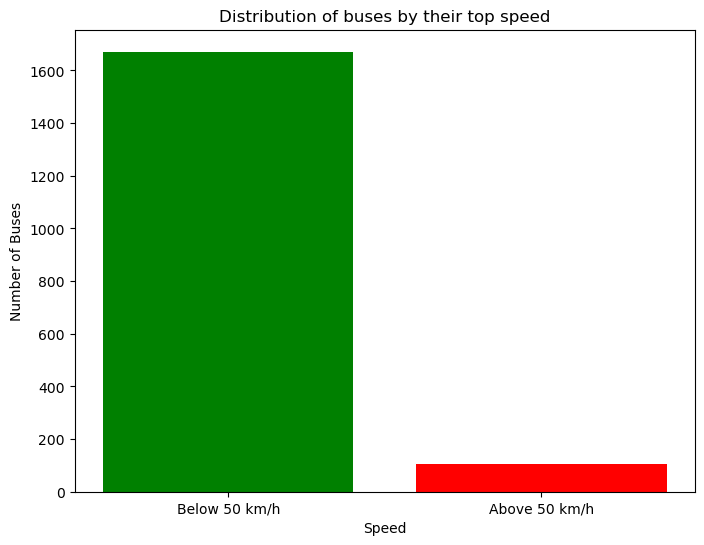

In [23]:
# Get all points with exceeded speed limit.
df_exceeded = df[df['speed'] > 50]

# Total number of buses
number_of_buses_total = df["VehicleNumber"].nunique()

# Number of buses that exceeded the speed limit.
number_of_buses_exceeded = df_exceeded["VehicleNumber"].nunique()


import matplotlib.pyplot as plt

# Plot.
plt.figure(figsize=(8, 6))
plt.bar(['Below 50 km/h', 'Above 50 km/h'],
        [number_of_buses_total - number_of_buses_exceeded, number_of_buses_exceeded],
        color=['green', 'red'])
plt.xlabel('Speed')
plt.ylabel('Number of Buses')
plt.title('Distribution of buses by their top speed')
plt.show()

### In what locations more than 50% of buses have exceeded the speed limit?

Lets define a location as a square with a middle point `p` and side `a`

### Find locations

In [40]:
# Side of the square in degrees on earth surface
a = 0.002

# Percentage
p = 0

# Middle points of locations with high percentage of speeding.
locations = []

# Lets use R-Tree to count quiqly the number of points within a square.

from rtree import index

p_index_all = index.Index()
p_index_exceeded = index.Index()

for idx, row in df.iterrows():
    lat = row['Lat']
    lon = row['Lon']
    p_index_all.insert(idx, (lon, lat, lon, lat))

for idx, row in df_exceeded.iterrows():
    lat = row['Lat']
    lon = row['Lon']
    p_index_exceeded.insert(idx, (lon, lat, lon, lat))

for idx, row in df.iterrows():
    lat = row['Lat']
    lon = row['Lon']

    # All points within the square centered in the point.
    neighbors_all = list(p_index_all.intersection((lon - a/2, lat - a/2, lon + a/2, lat + a/2)))
    
    # Points with exceeded speed limit within the square centered in the point.
    neighbors_exceeded = list(
        p_index_exceeded.intersection((lon - a/2, lat - a/2, lon + a/2, lat + a/2)))

    
    if len(neighbors_exceeded) / len(neighbors_all) > p:
        locations.append((lat, lon))
        
print(f"Number of locations: {len(locations)}")

Number of locations: 346


### Show them on map of Warsaw

In [41]:
from folium import folium
from folium.plugins import HeatMap

warsaw_coordinates = (52.2297, 21.0122)

# Create a map centered around Warsaw
map_warsaw = folium.Map(location=warsaw_coordinates, zoom_start=12)

# Create heatmap data
heat_data = [[point[0], point[1]] for point in locations]

# Add heatmap layer
HeatMap(heat_data, radius=15).add_to(map_warsaw)

map_warsaw